<a href="https://colab.research.google.com/github/ZahraBarati99/Deep-Model-Compression-via-Low-Rank-Decomposition/blob/main/CMD6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Imports

import torch
import torchvision.models as models
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Subset
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
import copy
import time


# بخش اول: تحلیل طیفی وزن‌های مدل

In [2]:
# Load pretrained ResNet-18
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
model.eval()

# Extracting the weights of one of the middle layers and the final layer
middle_layer  = model.layer2[0].conv1.weight.detach().cpu()
final_layer   = model.fc.weight.detach().cpu()

print("middle layer shape:", tuple(middle_layer.shape))
print("final layer shape:", tuple(final_layer.shape))

# Build matrix for SVD
middle_layer_matrix = middle_layer.reshape(middle_layer.shape[0], -1)

print("Matrix shape:", tuple(middle_layer_matrix.shape))

middle layer shape: (128, 64, 3, 3)
final layer shape: (1000, 512)
Matrix shape: (128, 576)


In [3]:
def spectrum_and_variance(W, title):

  S = torch.linalg.svdvals(W)

  variance = S**2
  cumulative_variance = torch.cumsum(variance, dim=0) / torch.sum(variance)

  k95 = int(torch.searchsorted(cumulative_variance, 0.95).item() + 1)

  print("-------------------------------------------------------------------------------------------------------------")
  print(f"{title}")
  print(f"Total singular values: {len(S)}")
  print(f"Singular values for 95% variance: {k95}")
  print(f"{100*k95/len(S):.2f}% percentage of values are enough to preserve 95% of the variance.\n")

  # Plot singular values
  plt.figure()
  plt.plot(S, marker='o')
  plt.title(f"{title}")
  plt.xlabel("Index")
  plt.ylabel("Singular Value")
  plt.grid(True)
  plt.show()

  # Plot cumulative variance
  plt.figure()
  plt.plot(cumulative_variance)
  plt.axhline(0.95, linestyle="--")
  plt.axvline(k95-1, linestyle="--")
  plt.title(f"{title} (k95={k95})")
  plt.xlabel("Index")
  plt.ylabel("Cumulative Variance")
  plt.grid(True)
  plt.show()

  return S, k95, cumulative_variance

-------------------------------------------------------------------------------------------------------------
Middle Layer
Total singular values: 128
Singular values for 95% variance: 94
73.44% percentage of values are enough to preserve 95% of the variance.



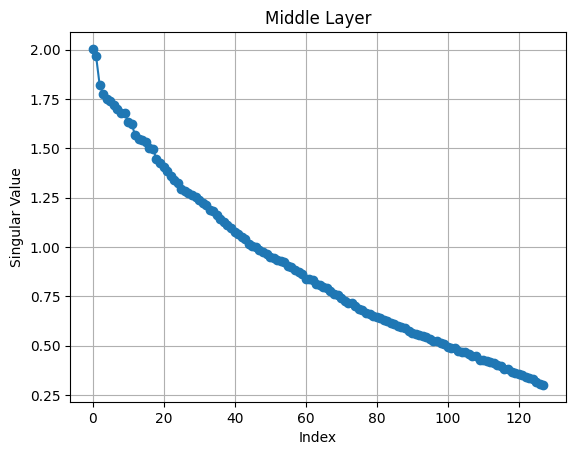

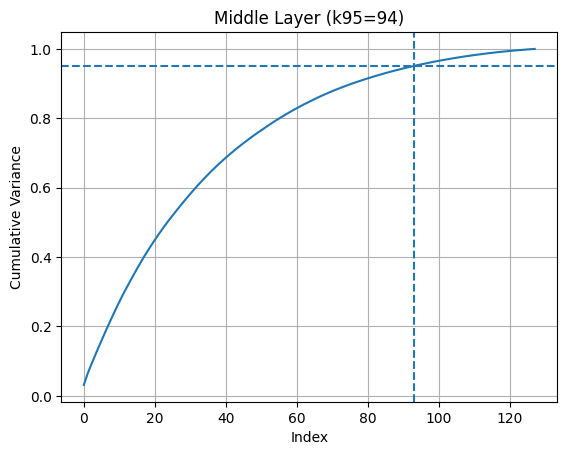

-------------------------------------------------------------------------------------------------------------
Final Layer
Total singular values: 512
Singular values for 95% variance: 291
56.84% percentage of values are enough to preserve 95% of the variance.



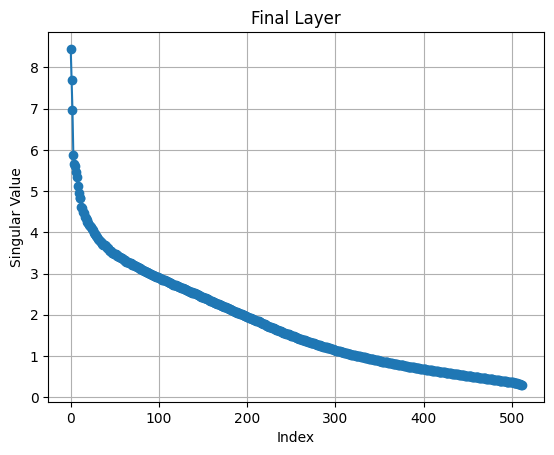

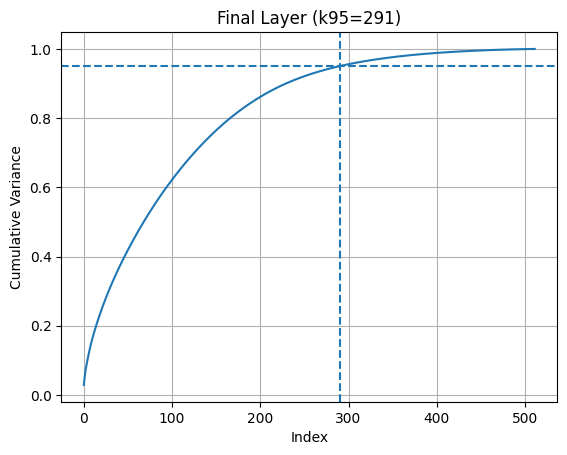

In [4]:
S_middle, k95_middle, cumulative_middle = spectrum_and_variance(middle_layer_matrix, "Middle Layer")
S_final,  k95_final,  cumulative_final  = spectrum_and_variance(final_layer, "Final Layer")

# بخش دوم: پیاده‌سازی عملی فشرده‌سازی

In [5]:
# Low-rank replacement for Linear (SVD)
@torch.no_grad()
def low_rank_linear_from_linear(layer, keep_ratio):
    W = layer.weight.detach().cpu()
    b = layer.bias.detach().cpu() if layer.bias is not None else None

    U, S, Vh = torch.linalg.svd(W, full_matrices=False)
    k = max(1, int(keep_ratio * S.numel()))

    first  = nn.Linear(W.shape[1], k, bias=False)
    second = nn.Linear(k, W.shape[0], bias=True)

    first.weight.copy_(Vh[:k, :])
    second.weight.copy_(U[:, :k] @ torch.diag(S[:k]))
    if b is not None:
        second.bias.copy_(b)
    else:
        second.bias.zero_()

    return nn.Sequential(first, second)

In [6]:
# Freeze backbone, train only fc
def freeze_backbone_train_fc(model):
    for p in model.parameters():
        p.requires_grad = False
    for p in model.fc.parameters():
        p.requires_grad = True

In [7]:
# Lightweight fine-tuning of the classifier head using a few batches
def finetune_fc(model, trainloader, device, epochs=1, lr=0.1, momentum=0.9, max_batches=None):
    freeze_backbone_train_fc(model)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.fc.parameters(), lr=lr, momentum=momentum)

    model.eval()
    model.fc.train()

    for ep in range(epochs):
        for i, (x, y) in enumerate(trainloader):
            if (max_batches is not None) and (i >= max_batches):
                break
            x, y = x.to(device), y.to(device)

            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()

    return model.eval()

In [8]:
@torch.no_grad()
def accuracy(model, loader, device, max_batches=None):
    model.eval()
    correct, total = 0, 0
    for i, (x, y) in enumerate(loader):
        if (max_batches is not None) and (i >= max_batches):
            break
        x, y = x.to(device), y.to(device)
        pred = model(x).argmax(1)
        correct += (pred == y).sum().item()
        total += y.size(0)
    return 100 * correct / max(total, 1)

In [9]:
def nparams(model):
    return sum(p.numel() for p in model.parameters())

In [10]:
# ImageNet preprocessing for pretrained ResNet-18
imagenet_transform = models.ResNet18_Weights.DEFAULT.transforms()
print(imagenet_transform)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [11]:
# Data (smaller input for speed)
fast_transform = transforms.Compose([
    transforms.Resize(128),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std =[0.229, 0.224, 0.225]),
])

trainset = datasets.CIFAR10("./data", train=True, transform=fast_transform, download=True)
testset  = datasets.CIFAR10("./data", train=False, transform=fast_transform, download=True)

In [12]:
# Very small subsets for speed
train_small = Subset(trainset, range(1024))
test_small  = Subset(testset,  range(512))

trainloader = DataLoader(train_small, batch_size=64, shuffle=True, num_workers=2)
testloader  = DataLoader(test_small,  batch_size=64, shuffle=False, num_workers=2)

In [13]:
device = "cpu"
print("device:", device)

# Build CIFAR-10 model
base = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
base.fc = nn.Linear(512, 10)
base = base.to(device)

device: cpu


In [14]:
base = finetune_fc(base, trainloader, device=device, epochs=1, max_batches=10)

In [15]:
# Compress copies
def compress_fc(model, keep_ratio):
    m = copy.deepcopy(model).to("cpu")
    m.fc = low_rank_linear_from_linear(m.fc, keep_ratio)
    return m.to(device).eval()

m50 = compress_fc(base, 0.5)
m80 = compress_fc(base, 0.2)

In [16]:
# Results
print("Results")
print(f"{'Model':<10} {'Params':>12} {'Acc':>8}")
print("----------------------------------")
print(f"{'base':<10} {nparams(base):>12,} {accuracy(base, testloader, device):>7.2f}%")
print(f"{'50%':<10} {nparams(m50):>12,} {accuracy(m50, testloader, device):>7.2f}%")
print(f"{'80%':<10} {nparams(m80):>12,} {accuracy(m80, testloader, device):>7.2f}%")

Results
Model            Params      Acc
----------------------------------
base         11,181,642   50.78%
50%          11,179,132   36.72%
80%          11,177,566   17.58%


# بخش سوم: بازیابی دقت و ارزیابی سرعت

In [17]:
EPOCHS = 3

m50 = finetune_fc(m50, trainloader, device=device, epochs=EPOCHS, lr=0.1, momentum=0.9, max_batches=None)
m80 = finetune_fc(m80, trainloader, device=device, epochs=EPOCHS, lr=0.1, momentum=0.9, max_batches=None)

In [18]:
@torch.no_grad()
def cpu_ms_per_batch(model, input_size=128, batch_size=64, warmup=10, runs=50):
    model = model.to("cpu").eval()
    x = torch.randn(batch_size, 3, input_size, input_size)

    # warmup
    with torch.inference_mode():
        for _ in range(warmup):
            _ = model(x)

    t0 = time.perf_counter()
    with torch.inference_mode():
        for _ in range(runs):
            _ = model(x)
    t1 = time.perf_counter()

    return (t1 - t0) * 1000.0 / runs

input_size = 128
batch_size = 64

ms_base = cpu_ms_per_batch(base, input_size=input_size, batch_size=batch_size)
ms_50   = cpu_ms_per_batch(m50,  input_size=input_size, batch_size=batch_size)
ms_80   = cpu_ms_per_batch(m80,  input_size=input_size, batch_size=batch_size)

print("\nCPU inference speed (ms/batch):")
print("base:", ms_base)
print("50% :", ms_50)
print("80% :", ms_80)


CPU inference speed (ms/batch):
base: 1830.2783873999942
50% : 1854.569476780016
80% : 1821.7951275799714



After fine-tune (Section 3):
Model            Params      Acc   CPU ms/batch
--------------------------------------------------
base         11,181,642   50.78%        1830.28
50%          11,179,132    8.01%        1854.57
80%          11,177,566    9.57%        1821.80


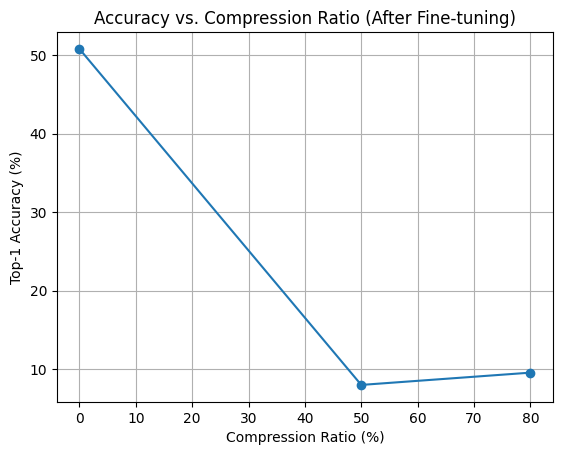

In [19]:
acc_base = accuracy(base, testloader, device=device, max_batches=None)
acc_50   = accuracy(m50,  testloader, device=device, max_batches=None)
acc_80   = accuracy(m80,  testloader, device=device, max_batches=None)

print("\nAfter fine-tune (Section 3):")
print(f"{'Model':<10} {'Params':>12} {'Acc':>8} {'CPU ms/batch':>14}")
print("-"*50)
print(f"{'base':<10} {nparams(base):>12,} {acc_base:>7.2f}% {ms_base:>14.2f}")
print(f"{'50%':<10} {nparams(m50):>12,} {acc_50:>7.2f}% {ms_50:>14.2f}")
print(f"{'80%':<10} {nparams(m80):>12,} {acc_80:>7.2f}% {ms_80:>14.2f}")

# Plot: accuracy vs compression rate
compression = [0, 50, 80]
accs = [acc_base, acc_50, acc_80]

plt.figure()
plt.plot(compression, accs, marker="o")
plt.xlabel("Compression Ratio (%)")
plt.ylabel("Top-1 Accuracy (%)")
plt.title("Accuracy vs. Compression Ratio (After Fine-tuning)")
plt.grid(True)
plt.show()